In [57]:
# Librerías

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de corpus

In [58]:
df_corpus = pd.read_csv('df_corpus.csv')
df_corpus.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,categoría,sentimiento,tokens,cleaned_text,review_length,cleaned_reviewText
0,A2VGK9S4DKTMF,B002V9X78U,BWallace,"[1, 1]",Let's be clear; I love how much I hate this pr...,1,"Lame, even for a white elephant gift",1386720000,2013-12-11,beauty,0,"['lets', 'clear', 'love', 'much', 'hate', 'pro...",lets clear love much hate product bought white...,121,let clear love much hate product bought white ...
1,A1N2EONG2Y6NUZ,B0001EL5R2,Shana,"[0, 0]","This made my skin so greasy and shiny, in addi...",1,Hello greasy skin!,1373587200,2013-07-12,beauty,0,"['made', 'skin', 'greasy', 'shiny', 'addition'...",made skin greasy shiny addition helping acne d...,23,made skin greasy shiny addition helping acne d...
2,ANWZD7ZYE50UE,B005MZS03C,Gilberto Prieto,"[0, 5]",i receive the perfume today and they are fake ...,1,FAKE!!!,1379894400,2013-09-23,beauty,0,"['receive', 'perfume', 'today', 'fake', 'also'...",receive perfume today fake also bought gucci g...,40,receive perfume today fake also bought gucci g...
3,A20RM3LL5IW5JO,B003UZ4R24,Oulzo,"[2, 7]",I got excited after seeing the multiple videos...,1,"Do not buy, the mask is full of alcohol!!!!!!!",1389398400,2014-01-11,beauty,0,"['got', 'excited', 'seeing', 'multiple', 'vide...",got excited seeing multiple videos youtube hea...,237,got excited seeing multiple video youtube heav...
4,A3E3GD3TABXKU1,B0017TZD7S,Loren w Christensen,"[2, 5]","Maybe I don't get the point with this. Okay, t...",2,don't get its purpose,1215734400,2008-07-11,beauty,0,"['maybe', 'dont', 'get', 'point', 'okay', 'use...",maybe dont get point okay use sex sell get sup...,165,maybe dont get point okay use sex sell get sup...


# Modelos

## División de muestra en train y test

In [59]:
y = df_corpus['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(df_corpus['cleaned_reviewText'], y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

print("Distribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

# Vamos a vectorizar usando TfidfVectorizer 
tfidf_vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))  
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

Distribución de clases en el conjunto de entrenamiento:
sentimiento
1    0.5
0    0.5
Name: proportion, dtype: float64


## Entrenamos con Naive Bayes y Regresión Logística

In [60]:
# Modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Modelo Regresión Logística
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)


## Resultados

In [61]:
def print_metrics(y_true, y_pred, model_name):
    print(f"Resultados del modelo {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_nb, "Naive Bayes")

print_metrics(y_test, y_pred_lr, "Regresión Logística")

Resultados del modelo Naive Bayes:
Accuracy: 0.8346
Precision: 0.8373
Recall: 0.8306
F1 Score: 0.8339
Resultados del modelo Regresión Logística:
Accuracy: 0.8446
Precision: 0.8509
Recall: 0.8356
F1 Score: 0.8432


In [62]:
# Voy a guardar las predicciones para el siguiente paso donde haremos un reporte de métricas

predictions_df = pd.DataFrame({
    'true_labels': y_test,
    'nb_predictions': y_pred_nb,
    'lr_predictions': y_pred_lr
})

predictions_df.to_csv('model_predictions.csv', index=False)

# Primeras conclusiones

- A priori, la Regresión Logística parece dar mejores resultados que Naive Bayes.

## Extra: Probamos a añadir un nuevo comentario para que clasifique el sentimiento con Regresión Logística y ver cómo lo hace

In [63]:
# Guardo el modelo de Regresión Logística y el vectorizador
joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Los cargo 
loaded_lr_model = joblib.load('logistic_regression_model.pkl')
loaded_tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Nuevo comentario
new_comment = "I really liked the product, I would buy it again"

# Preprocesamiento
def remove_accents(text):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_non_letters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords.words('english')]

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess_text(text):
    text = text.lower()
    text = remove_accents(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'\[.*?\]', '', text) 
    text = remove_non_letters(text)
    tokens = word_tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)

    return ' '.join(tokens)

cleaned_comment = preprocess_text(new_comment)

# Vectorizo el nuevo comentario
new_comment_vectorized = loaded_tfidf_vectorizer.transform([cleaned_comment])

# Predicción 
predicted_prob_lr = loaded_lr_model.predict_proba(new_comment_vectorized)[:, 1][0]
predicted_sentiment_lr = loaded_lr_model.predict(new_comment_vectorized)[0]

# Resultado
print(f"Comentario original: {new_comment}")
print(f"Comentario preprocesado: {cleaned_comment}")
print(f"Probabilidad predicha (clase positiva): {predicted_prob_lr:.4f}")
print(f"Sentimiento predicho: {'Positivo' if predicted_sentiment_lr == 1 else 'Negativo'}")


Comentario original: I really liked the product, I would buy it again
Comentario preprocesado: really liked product would buy
Probabilidad predicha (clase positiva): 0.2617
Sentimiento predicho: Negativo


In [64]:
# El resultado claramente es falso, ya que el comentario es positivo pero me lo devuelve como negativo.
# Voy a verificar el balance de clases y el overfitting

Distribución de clases en el conjunto de entrenamiento:
sentimiento
1    0.5
0    0.5
Name: proportion, dtype: float64
Distribución de clases en el conjunto de prueba:
sentimiento
1    0.500083
0    0.499917
Name: proportion, dtype: float64


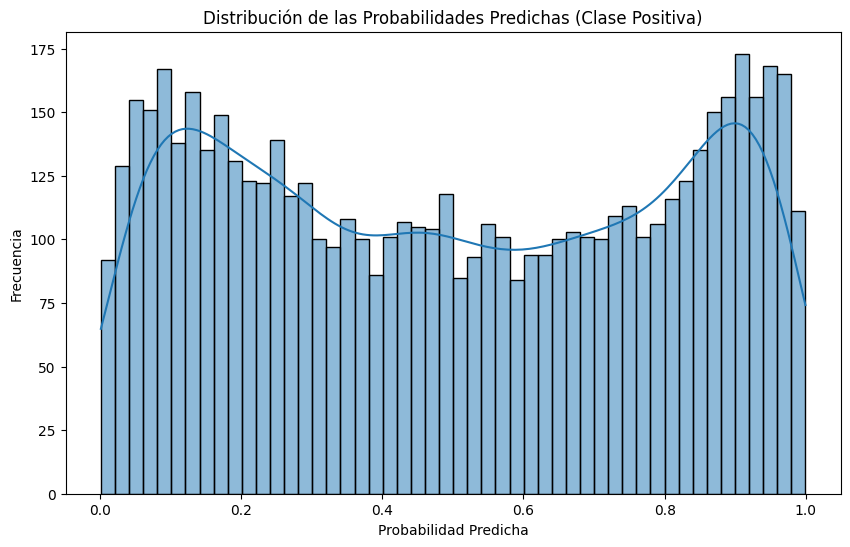

In [65]:
print("Distribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("Distribución de clases en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))

y_prob_test = lr_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 6))
sns.histplot(y_prob_test, bins=50, kde=True)
plt.title('Distribución de las Probabilidades Predichas (Clase Positiva)')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia')
plt.show()


In [66]:
# La distribución de clases parece adecuada

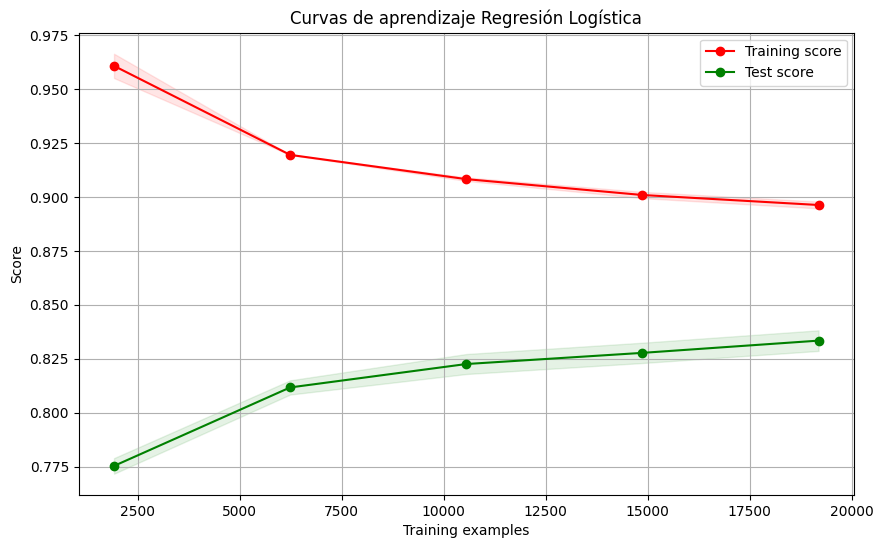

In [67]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")
    plt.legend(loc="best")
    
    return plt

# Genero las curvas de aprendizaje para el modelo de regresión logística
plot_learning_curve(lr_model, "Curvas de aprendizaje Regresión Logística", X_train, y_train, cv=5, n_jobs=-1)
plt.show()


In [68]:
# Las curvas nos muestran que puede haber presencia de overfitting al haber diferencias significativas entre ellas.
# Esto podría estar haciendo que el modelo no generalice bien cuando introducimos nuevos datos.
# Podríamos probar a regularizar para ver si conseguimos mejorarlo.